# Error Analysis

Find localisation error using control lines

The strategy is the following:

- Register points across channels before and after chromatic aberration correction
- Do the step above using multiple distance cutoff on registration
- Error will be given by the standard deviation of the distances after correction

In [1]:
import glob
import sys
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy
import scipy.optimize
sys.path.append("../source/")
from dual_channel_analysis.utils import (
    chromatic_aberration_correction,
    compute_affine_transform,
)
from IPython.display import Markdown as md
matplotlib.use("Agg")

%matplotlib inline

In [7]:
def register_points_using_euclidean_distance(
    reference: pd.DataFrame, moving: pd.DataFrame, distance_cutoff: float = 0.1
):
    """Given dataframe containing reference and moving coordinates, get the two sets of matched points"""

    cdist = scipy.spatial.distance.cdist(reference, moving, metric="euclidean")
    rows, cols = scipy.optimize.linear_sum_assignment(cdist)
    for r, c in zip(rows, cols):
        if cdist[r, c] > distance_cutoff:
            rows = rows[rows != r]
            cols = cols[cols != c]

    reference = np.array([reference[i] for i in rows])
    moving = np.array([moving[i] for i in cols])

    return reference, moving


def calculate_deviation_registred_points(channel1_files, channel2_files, path_beads):
    res = pd.DataFrame()

    for dist_cutoff in [0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

        channel1_coords = []
        channel2_coords = []
        channel1_coords_after_correction = []
        channel2_coords_after_correction = []

        for idx in range(len(channel1_files)):

            channel1 = pd.read_csv(channel1_files[idx])
            channel2 = pd.read_csv(channel2_files[idx])

            (
                channel1_coords_curr,
                channel2_coords_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2[[X, Y, Z]].values,
                distance_cutoff=dist_cutoff,
            )

            (
                channel2_coords_after_correction_curr,
                sx,
                sy,
                sz,
            ) = chromatic_aberration_correction(
                directory=path_beads,
                coords=channel2[[X, Y, Z]].values,
                channel_to_correct=2,
                distance_cutoff=0.1,
                quality=f"{outdir}/chromatic_aberration_correction_quality.pdf",
            )

            (
                channel1_coords_after_correction_curr,
                channel2_coords_after_correction_curr,
            ) = register_points_using_euclidean_distance(
                reference=channel1[[X, Y, Z]].values,
                moving=channel2_coords_after_correction_curr,
                distance_cutoff=dist_cutoff,
            )

            if len(channel1_coords_curr):
                channel1_coords.append(channel1_coords_curr)

            if len(channel2_coords_curr):
                channel2_coords.append(channel2_coords_curr)

            if len(channel1_coords_after_correction_curr):
                channel1_coords_after_correction.append(
                    channel1_coords_after_correction_curr
                )
            if len(channel2_coords_after_correction_curr):
                channel2_coords_after_correction.append(
                    channel2_coords_after_correction_curr
                )

        if len(channel1_coords) == 0 and len(channel1_coords_after_correction) == 0:
            continue
        channel1_coords = np.concatenate(channel1_coords)
        channel2_coords = np.concatenate(channel2_coords)
        channel1_coords_after_correction = np.concatenate(
            channel1_coords_after_correction
        )
        channel2_coords_after_correction = np.concatenate(
            channel2_coords_after_correction
        )
        
        t, A = compute_affine_transform(channel1_coords_after_correction, channel2_coords_after_correction)
        channel2_coords_after_correction = np.transpose(np.dot(A, channel2_coords_after_correction.T)) + t

        dist1 = np.sqrt(
            np.sum(
                np.square(
                    channel1_coords_after_correction - channel2_coords_after_correction
                ),
                axis=1,
            )
        )
        
        
        dist2 = np.sqrt(
            np.sum(
                np.square(channel1_coords - channel2_coords),
                axis=1,
            )
        )
        tmp = pd.DataFrame(dist1, columns=["distance_after"])
        tmp["dist_cutoff"] = dist_cutoff
        
        axis = ["x", "y", "z"]
        for i in range(len(axis)):
            diff1 = (
                channel1_coords_after_correction[..., i]
                - channel2_coords_after_correction[..., i]
            )
            diff2 = channel1_coords[..., i] - channel2_coords[..., i]

            tmp[f"{axis[i]}_after"] = diff1
        #    tmp[f"{axis[i]}_before"] = diff2
            res = pd.concat([res, tmp])
    return res


def plotres(res):
    fig, ax = plt.subplots(3, 4, figsize=(15, 15))
    axis = ["x", "y", "z"]
    i = 0
    selection = res.axis == axis[i]
    ax[0, i].plot(res.dist_cutoff[selection], res.number_points_before[selection], "-o")
    ax[0, i].set_ylabel("Number of registred points")
    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[1, i].axhline(y=0, color="r", linestyle="-")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_before[selection], "-o")
        ax[1, i].plot(res.dist_cutoff[selection], res.mean_after[selection], "-o")
        ax[1, i].legend(["Before correction", "After correction"])
        if i == 0:
            ax[1, i].set_ylabel("Average distance between registred spots")
        ax[1, i].set_title(f"Along {axis[i]}")

    ax[1, 3].plot(res.dist_cutoff[selection], res.mean_before_distance[selection], "-o")
    ax[1, 3].plot(res.dist_cutoff[selection], res.mean_after_distance[selection], "-o")
    ax[1, 3].legend(["Before correction", "After correction"])
    ax[1, 3].set_title(f"radial distance")

    for i in range(len(axis)):
        selection = res.axis == axis[i]
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_before[selection], "-o")
        ax[2, i].plot(res.dist_cutoff[selection], res.sd_after[selection], "-o")
        ax[2, i].legend(["Before correction", "After correction"])
        ax[2, i].set_xlabel("Distance cutoff for points registration")
        if i == 0:
            ax[2, i].set_ylabel("STD of distance between registred spots")
    plt.suptitle(f"{outdir}", fontsize=20)

    ax[2, 3].plot(res.dist_cutoff[selection], res.sd_before_distance[selection], "-o")
    ax[2, 3].plot(res.dist_cutoff[selection], res.sd_after_distance[selection], "-o")
    ax[2, 3].legend(["Before correction", "After correction"])
    ax[2, 3].set_xlabel("Distance cutoff for points registration")

    plt.savefig(f"{outdir}/{outname}.error_analysis.pdf")
    plt.show()

In [8]:
TRACKID = "track"
X = "x"
Y = "y"
Z = "z"
FRAME = "frame"
CELLID = "cell"
basedir = "/tungstenfs/scratch/ggiorget/zhan/2021/1105_pia_image_analysis/3d_prediction/two_colours_lines/control_lines_new/"

In [9]:
res = pd.DataFrame()
outdir = f"{basedir}/"
outname = "alldatapooled"
for sample in glob.glob(f"{basedir}/*/"):
    path_beads = f"{sample}/beads/um_based/"
    path_images_to_correct = f"{sample}/um_based/"

    channel1_files = sorted(glob.glob(f"{path_images_to_correct}/*w1*csv"))
    names = [re.search(r"(^.*)w1", os.path.basename(x))[1] for x in channel1_files]
    channel2_files = [
        glob.glob(f"{path_images_to_correct}/{name}*w2*csv")[0] for name in names
    ]

    tmp = calculate_deviation_registred_points(channel1_files, channel2_files, path_beads)
    tmp["exp"] = sample
    res = pd.concat([tmp, res])

# plotres(res0)
# md(
#     f"Ideal cutoff point registration cutoff seems to be 0.3um. This leads to the following offset  {res0[round(res0.dist_cutoff, 1)==0.3]['mean_after_distance'].values[0]} +/- {res0[round(res0.dist_cutoff, 1)==0.3]['sd_after_distance'].values[0]}"
# )

Text(0, 0.5, 'Number of registred spots')

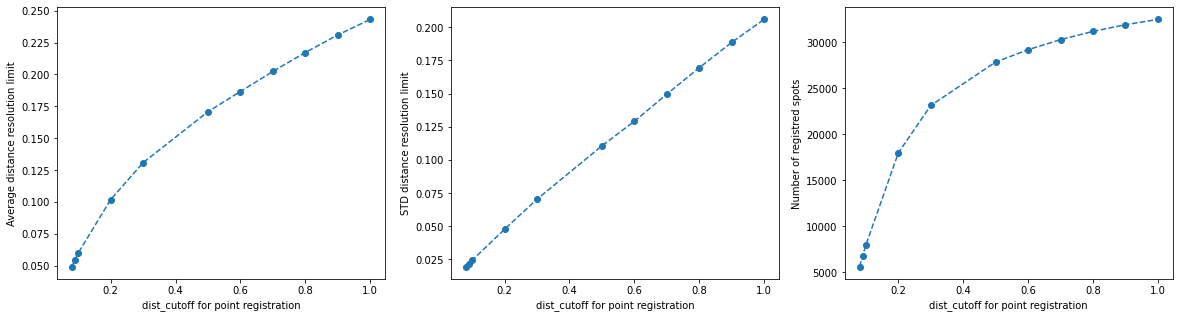

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].plot(res.groupby("dist_cutoff").mean()["distance_after"], "--o")
ax[0].set_xlabel("dist_cutoff for point registration")
ax[0].set_ylabel("Average distance resolution limit")

ax[1].plot(res.groupby("dist_cutoff").std()["distance_after"], "--o")
ax[1].set_xlabel("dist_cutoff for point registration")
ax[1].set_ylabel("STD distance resolution limit")


ax[2].plot(res.groupby("dist_cutoff")["distance_after"].apply(lambda x: len(x)), "--o")
ax[2].set_xlabel("dist_cutoff for point registration")
ax[2].set_ylabel("Number of registred spots")

In [11]:
print(np.mean(res[res['dist_cutoff'] == 0.3]['distance_after']), "+/-", np.std(res[res['dist_cutoff'] == 0.3]['distance_after']))

0.13080842358779546 +/- 0.0703892820954766
